# Laplace on a sinuisoidal toy example

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

/Users/warburg/miniconda3/envs/laplace/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create training and test data

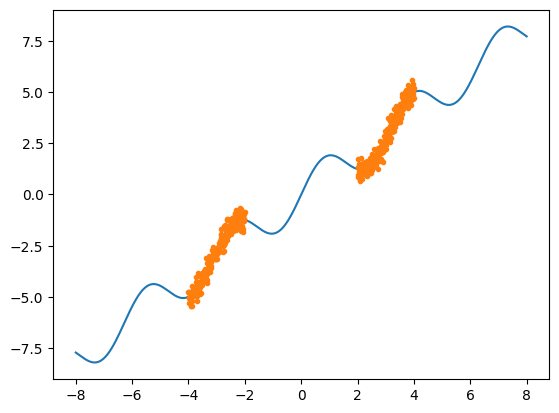

In [2]:
def f(x):
    # y = np.sin(2*x) + x + 0.3 * np.sin(50*x)
    y = np.sin(2 * x) + x
    return y


N = 1000
x_train = np.linspace(-4, 4, N)
x_train_all = x_train
mask = (x_train > 2) | (x_train < -2)
x_train_masked = x_train[~mask]
x_train = torch.from_numpy(x_train[mask]).float()
y_train = f(x_train) + 0.3 * np.random.randn(len(x_train))

x_test = np.linspace(-8, 8, 2 * N)
y_test = f(x_test)

# def get_sinusoid_example(n_data=150, sigma_noise=0.3, batch_size=150):
#     # create simple sinusoid data set
#     X_train = (torch.rand(n_data) * 8).unsqueeze(-1)
#     y_train = torch.sin(X_train) + torch.randn_like(X_train) * sigma_noise
#     X_test = torch.linspace(-5, 13, 500).unsqueeze(-1)
#     y_test = torch.sin(X_test)
#     return X_train, y_train, X_test.numpy().reshape(-1), y_test.numpy().reshape(-1)

# x_train, y_train, x_test, y_test = get_sinusoid_example()

plt.plot(x_test, y_test, "-")
plt.plot(x_train, y_train, ".")

# Define model, training and evaluation loops


In [3]:
def make_mlp(input_dim, hidden_dim, output_dim, num_layers):
    layers = []
    layers.append(nn.Linear(input_dim, hidden_dim))
    layers.append(nn.Tanh())
    for _ in range(num_layers - 2):
        layers.append(nn.Linear(hidden_dim, hidden_dim, bias=True))
        layers.append(nn.Tanh())
    layers.append(nn.Linear(hidden_dim, output_dim, bias=True))

    return nn.Sequential(*layers)


def train_model(model, epochs, x, y, device):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    x, y = x.to(device), y.to(device)

    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    loss_history = []
    for i in range(epochs):
        optimizer.zero_grad()

        pred = model(x)
        loss = torch.mean(torch.mean((pred - y) ** 2, dim=-1))
        loss.backward()
        optimizer.step()

        if i % 500 == 0:
            print(f"Epoch {i}, loss {loss.item()}")

        loss_history.append(loss.item())

    return {"loss_history": loss_history}


def test_model(model, x_test, device):
    model.eval()
    x = torch.tensor(x_test, dtype=torch.float32)
    x = x.to(device).reshape(-1, 1)

    with torch.no_grad():
        pred = model(x)

    return {"pred": pred}

# Train model

/var/folders/tp/k8_xb41s1hqc7d25x2j_3bbw0000gn/T/ipykernel_6698/3856371011.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
/var/folders/tp/k8_xb41s1hqc7d25x2j_3bbw0000gn/T/ipykernel_6698/3856371011.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


Epoch 0, loss 9.230623245239258
Epoch 500, loss 0.1441941261291504
Epoch 1000, loss 0.08387143164873123
Epoch 1500, loss 0.08355531096458435
Epoch 2000, loss 0.08345416933298111
Epoch 2500, loss 0.08342262357473373
Epoch 3000, loss 0.0834110900759697
Epoch 3500, loss 0.08338368684053421
Epoch 4000, loss 0.08332019299268723
Epoch 4500, loss 0.08321623504161835


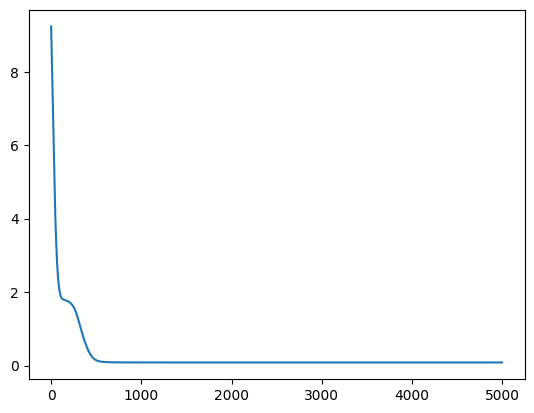

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = make_mlp(1, 16, 1, 4)
model = model.to(device)

out = train_model(model, 5000, x_train, y_train, device)

plt.plot(out["loss_history"])
plt.show()

# Show model fit

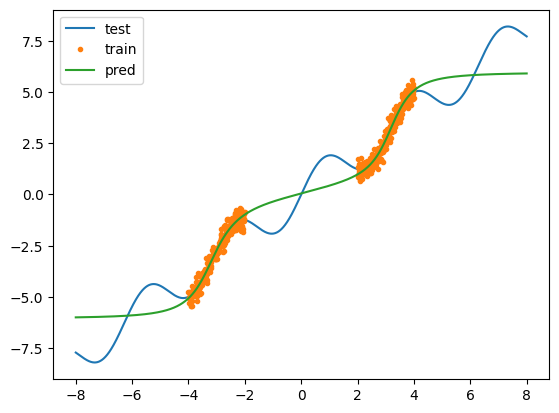

In [5]:
out = test_model(model, x_test, device)


plt.plot(x_test, y_test, "-", label="test")
plt.plot(x_train, y_train, ".", label="train")
plt.plot(x_test, out["pred"].cpu().numpy(), label="pred")
plt.legend()
plt.show()

# Perform Laplace Approximation on the model

In [6]:
from nnj.utils import convert_to_nnj
from pytorch_laplace import MSEHessianCalculator
from pytorch_laplace.laplace.diag import DiagLaplace
from pytorch_laplace.optimization.prior_precision import optimize_prior_precision
from torch.nn.utils import parameters_to_vector, vector_to_parameters

In [7]:
def fit_hessian(model, x, batch_size=1024):
    model.eval()

    hessian_calculator = MSEHessianCalculator(
        wrt="weight",
        hesian_shape="diag",
        approximation_accuracy="exact",
    )

    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    hessian = torch.zeros_like(parameters_to_vector(model.parameters()), device=device)
    for i in range(0, x.shape[0], batch_size):
        with torch.no_grad():
            model(x[i : i + batch_size])

            h = hessian_calculator.compute_hessian(x=x[i : i + batch_size], model=model)
            hessian += h * batch_size

        if i % 100 == 0:
            print(f"{i}, {hessian.max()} {hessian.min()}")

    return hessian

# Convert to nnj and fit hessian

In [8]:
nnj_model = convert_to_nnj(model)
nnj_model.eval()

model_input = x_train.to(device).reshape(-1, 1)
hessian = fit_hessian(nnj_model, model_input, batch_size=1024)

0, 12588.69140625 1.0444931983947754


# Visualize Laplace predictions

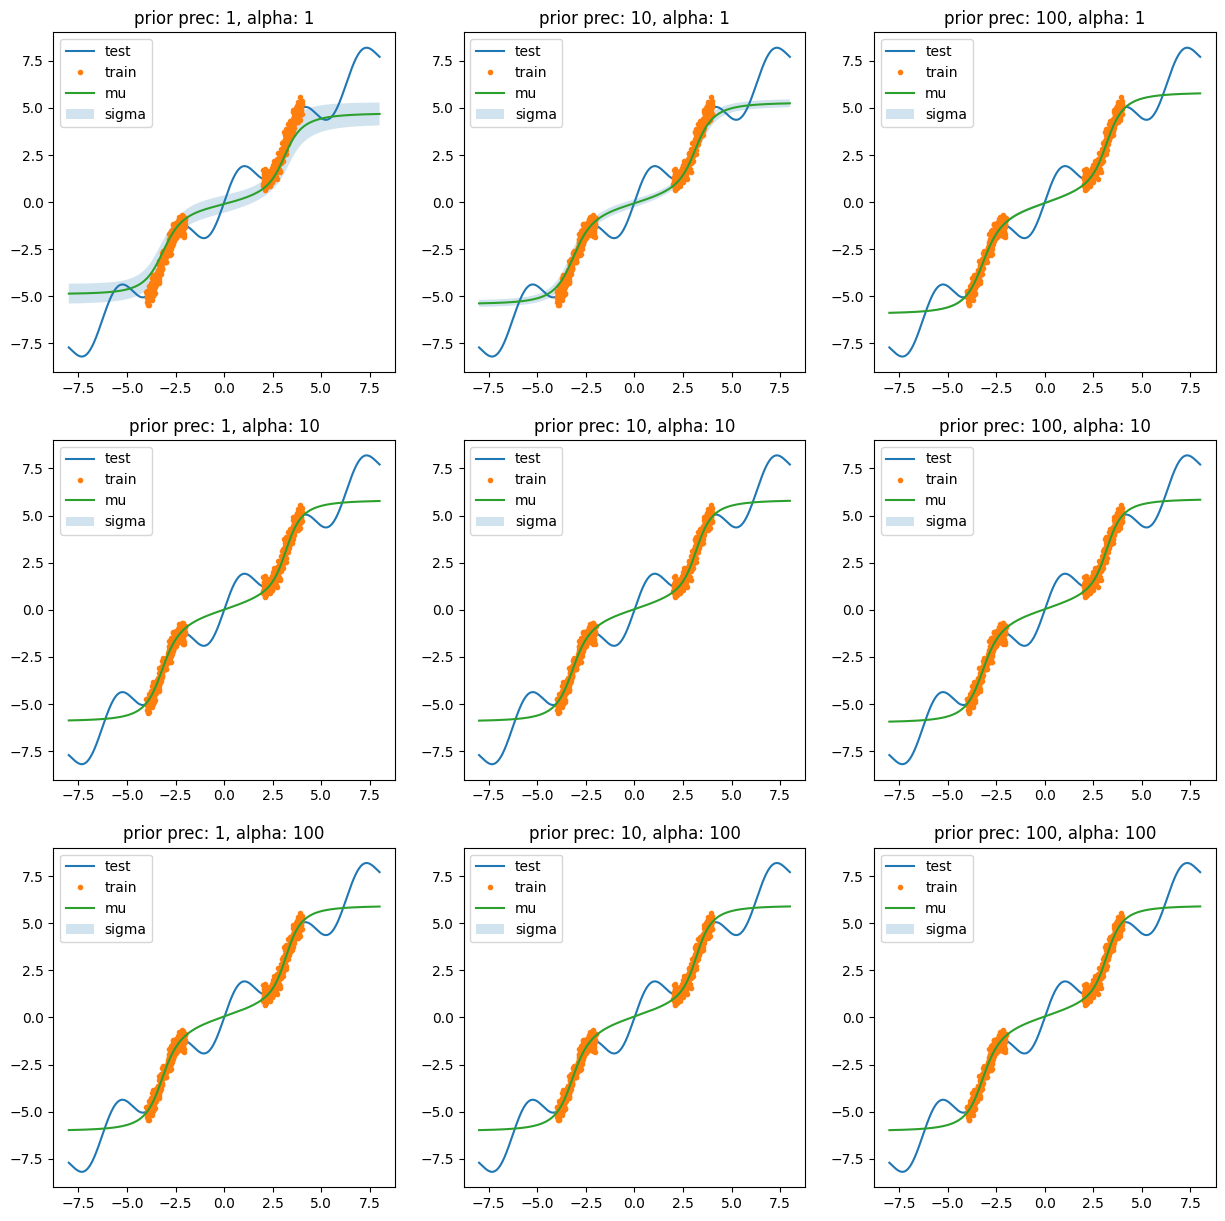

In [9]:
sampler = DiagLaplace(backend="nnj")

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for j, alpha in enumerate([1, 10, 100]):
    for i, prior_prec in enumerate([1, 10, 100]):
        model_input = torch.from_numpy(x_test.reshape(-1, 1)).type(torch.float32).to(device)
        mu, sigma = sampler.laplace(
            x=model_input,
            model=nnj_model,
            hessian=hessian,
            scale=alpha,
            prior_prec=prior_prec,
            n_samples=100,
        )

        mu = mu.cpu().numpy().reshape(-1)
        sigma = sigma.cpu().numpy().reshape(-1)

        ax[j, i].plot(x_test, y_test, "-", label="test")
        ax[j, i].plot(x_train, y_train, ".", label="train")
        ax[j, i].plot(x_test, mu, label="mu")
        ax[j, i].fill_between(x_test, mu - sigma, mu + sigma, alpha=0.2, label="sigma")
        ax[j, i].legend()
        ax[j, i].set_title(f"prior prec: {prior_prec}, alpha: {alpha}")
plt.show()

# Visualize Linearized Laplace predictions

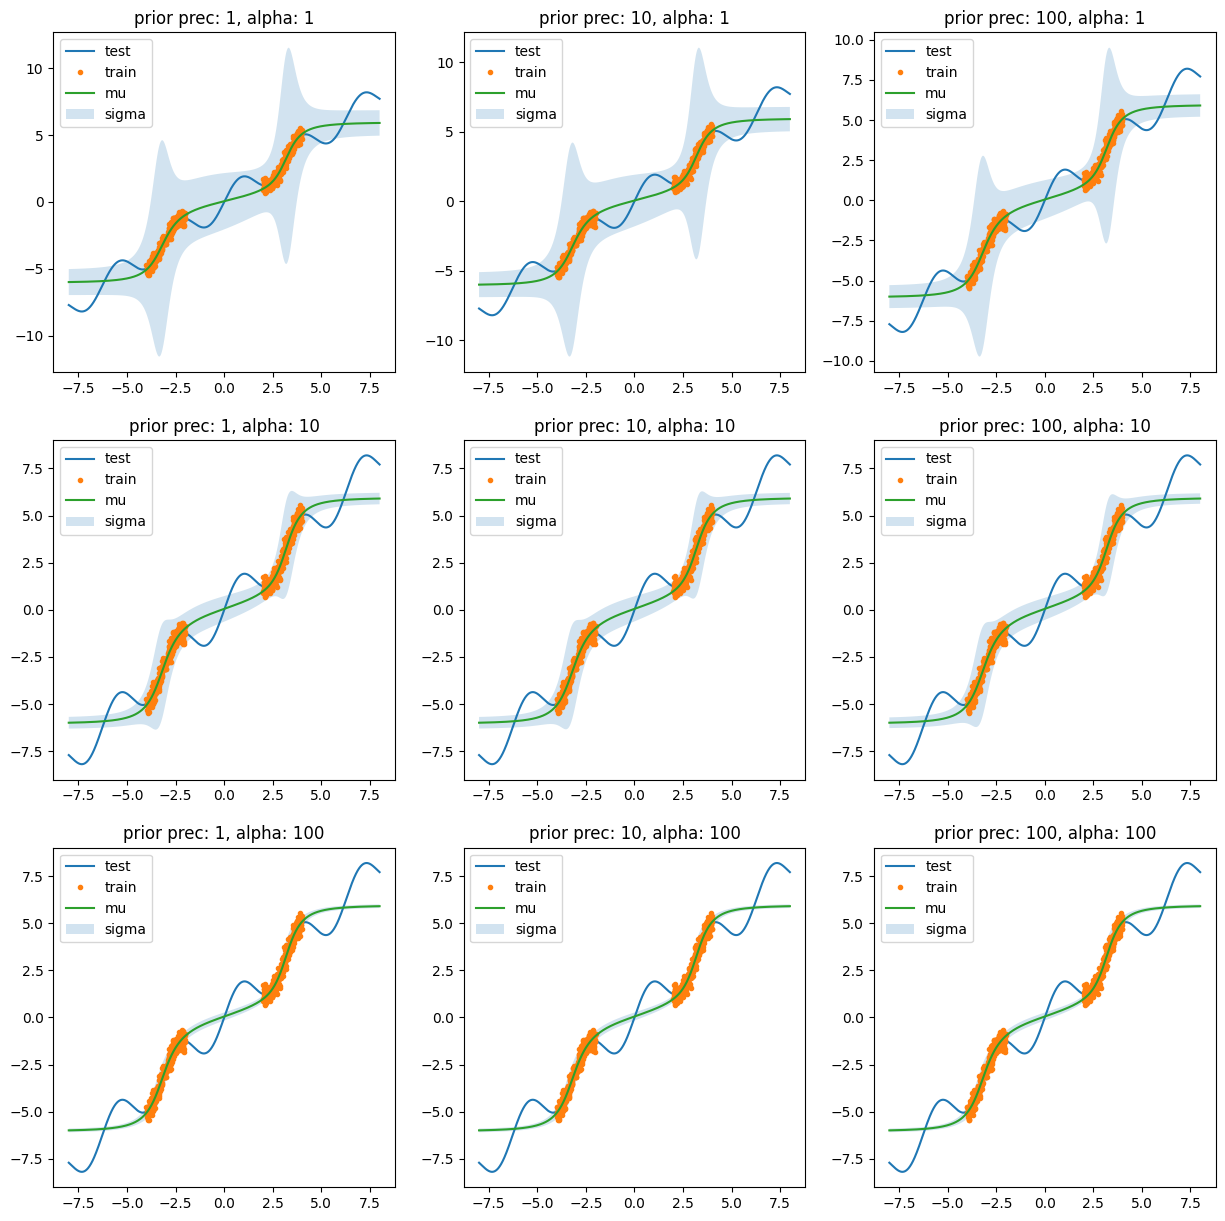

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for j, alpha in enumerate([1, 10, 100]):
    for i, prior_prec in enumerate([1, 10, 100]):
        with torch.no_grad():
            model_input = torch.from_numpy(x_test.reshape(-1, 1)).type(torch.float32).to(device)
            mu, sigma = sampler.linearized_laplace(
                x=model_input,
                model=nnj_model,
                hessian=hessian,
                scale=alpha,
                prior_prec=prior_prec,
            )

        mu = mu.cpu().numpy().reshape(-1)

        sigma = sigma.cpu().numpy().reshape(-1)

        ax[j, i].plot(x_test, y_test, "-", label="test")
        ax[j, i].plot(x_train, y_train, ".", label="train")
        ax[j, i].plot(x_test, mu, label="mu")
        ax[j, i].fill_between(x_test, mu - sigma, mu + sigma, alpha=0.2, label="sigma")
        ax[j, i].legend()
        ax[j, i].set_title(f"prior prec: {prior_prec}, alpha: {alpha}")
plt.show()